In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.spatial.transform import Rotation
from plyfile import PlyData, PlyElement
from sklearn.cluster import KMeans
from tqdm import tqdm

import util
from util import Camera
from util_gau import load_ply, GaussianData

In [2]:
g_width, g_height = 1280, 720
scale_modifier = 1.0

SH_C0 = 0.28209479177387814
SH_C1 = 0.4886025119029199
SH_C2_0 = 1.0925484305920792
SH_C2_1 = -1.0925484305920792
SH_C2_2 = 0.31539156525252005
SH_C2_3 = -1.0925484305920792
SH_C2_4 = 0.5462742152960396
SH_C3_0 = -0.5900435899266435
SH_C3_1 = 2.890611442640554
SH_C3_2 = -0.4570457994644658
SH_C3_3 = 0.3731763325901154
SH_C3_4 = -0.4570457994644658
SH_C3_5 = 1.445305721320277
SH_C3_6 = -0.5900435899266435

class Gaussian:
    def __init__(self, pos, scale, rot, opacity, sh, lod=0):
        self.pos = np.array(pos)
        self.scale = np.array(scale_modifier * scale)
        self.rot = sp.spatial.transform.Rotation.from_quat([rot[1], rot[2], rot[3], rot[0]])
        self.opacity = opacity[0]
        self.sh = np.array(sh)
        self.cov3D = self.compute_cov3d()
        self.lod = lod

    def compute_cov3d(self):
        cov3D = np.diag(self.scale**2)
        cov3D = self.rot.as_matrix().T @ cov3D @ self.rot.as_matrix()
        return cov3D

    def get_cov2d(self, camera):
        view_mat = camera.get_view_matrix()
        g_pos_w = np.append(self.pos, 1.0)
        g_pos_cam = view_mat @ g_pos_w
        view_matrix = camera.get_view_matrix()
        [htan_fovx, htan_fovy, focal] = camera.get_htanfovxy_focal()
        focal_x = focal_y = focal

        t = np.copy(g_pos_cam)

        limx = 1.3 * htan_fovx
        limy = 1.3 * htan_fovy
        txtz = t[0]/t[2]
        tytz = t[1]/t[2]

        tx = min(limx, max(-limx, txtz)) * t[2]
        ty = min(limy, max(-limy, tytz)) * t[2]
        tz = t[2]

        J = np.array([
            [focal_x/tz, 0.0, -(focal_x * tx)/(tz * tz)],
            [0.0, focal_y/tz, -(focal_y * ty)/(tz * tz)],
            [0.0, 0.0, 0.0]
        ])
        W = view_matrix[:3, :3].T
        T = W @ J
        cov = T.T @ self.cov3D.T @ T

        cov[0,0] += 0.3
        cov[1,1] += 0.3
        return cov[:2, :2]

    def get_depth(self, camera):
        view_matrix = camera.get_view_matrix()
        
        position4 = np.append(self.pos, 1.0)
        g_pos_view = view_matrix @ position4
        depth = g_pos_view[2]
        return depth

    def get_conic_and_bb(self, camera):
        cov2d = self.get_cov2d(camera)

        det = np.linalg.det(cov2d)
        if det == 0.0:
            return None
        
        det_inv = 1.0 / det
        cov = [cov2d[0,0], cov2d[0,1], cov2d[1,1]]
        conic = np.array([cov[2] * det_inv, -cov[1] * det_inv, cov[0] * det_inv])
        bboxsize_cam = np.array([3.0 * np.sqrt(cov2d[0,0]), 3.0 * np.sqrt(cov2d[1,1])])
        wh = np.array([camera.w, camera.h])
        bboxsize_ndc = np.divide(bboxsize_cam, wh) * 2

        vertices = np.array([[-1, 1], [1, 1], [1, -1], [-1, -1]])
        bboxsize_cam = np.multiply(vertices, bboxsize_cam)

        view_matrix = camera.get_view_matrix()
        projection_matrix = camera.get_projection_matrix()

        position4 = np.append(self.pos, 1.0)
        g_pos_view = view_matrix @ position4
        g_pos_screen = projection_matrix @ g_pos_view
        g_pos_screen = g_pos_screen / g_pos_screen[3]
        
        bbox_ndc = np.multiply(vertices, bboxsize_ndc) + g_pos_screen[:2]
        bbox_ndc = np.hstack((bbox_ndc, np.zeros((vertices.shape[0],2))))
        bbox_ndc[:,2:4] = g_pos_screen[2:4]

        return conic, bboxsize_cam, bbox_ndc

    def get_color(self, dir) -> np.ndarray:
        c0 = self.sh[0:3]
        color = SH_C0 * c0

        shdim = len(self.sh)

        if shdim > 3:
            # Add the first order spherical harmonics
            c1 = self.sh[3:6]
            c2 = self.sh[6:9]
            c3 = self.sh[9:12]
    
            x = dir[0]
            y = dir[1]
            z = dir[2]
            color = color - SH_C1 * y * c1 + SH_C1 * z * c2 - SH_C1 * x * c3
            
        if shdim > 12:
            c4 = self.sh[12:15]
            c5 = self.sh[15:18]
            c6 = self.sh[18:21]
            c7 = self.sh[21:24]
            c8 = self.sh[24:27]
    
            (xx, yy, zz) = (x * x, y * y, z * z)
            (xy, yz, xz) = (x * y, y * z, x * z)
            
            color = color +	SH_C2_0 * xy * c4 + \
                SH_C2_1 * yz * c5 + \
                SH_C2_2 * (2.0 * zz - xx - yy) * c6 + \
                SH_C2_3 * xz * c7 + \
                SH_C2_4 * (xx - yy) * c8

        if shdim > 27:
            c9 = self.sh[27:30]
            c10 = self.sh[30:33]
            c11 = self.sh[33:36]
            c12 = self.sh[36:39]
            c13 = self.sh[39:42]
            c14 = self.sh[42:45]
            c15 = self.sh[45:48]
    
            color = color + \
                SH_C3_0 * y * (3.0 * xx - yy) * c9 + \
                SH_C3_1 * xy * z * c10 + \
                SH_C3_2 * y * (4.0 * zz - xx - yy) * c11 + \
                SH_C3_3 * z * (2.0 * zz - 3.0 * xx - 3.0 * yy) * c12 + \
                SH_C3_4 * x * (4.0 * zz - xx - yy) * c13 + \
                SH_C3_5 * z * (xx - yy) * c14 + \
                SH_C3_6 * x * (xx - 3.0 * yy) * c15
        
        color += 0.5
        return np.clip(color, 0.0, 1.0)

In [3]:
def plot_opacity(gaussian: Gaussian, camera: Camera, w: int, h: int, bitmap: np.ndarray, alphas: np.ndarray):
    conic, bboxsize_cam, bbox_ndc = gaussian.get_conic_and_bb(camera)

    A, B, C = conic

    screen_height, screen_width = bitmap.shape[:2]
    bbox_screen = camera.ndc_to_pixel(bbox_ndc, screen_width, screen_height)
    
    if np.any(np.isnan(bbox_screen)):
        return

    ul = bbox_screen[0,:2]
    ur = bbox_screen[1,:2]
    lr = bbox_screen[2,:2]
    ll = bbox_screen[3,:2]
    
    y1 = int(np.floor(ul[1]))
    y2 = int(np.ceil(ll[1]))
    
    x1 = int(np.floor(ul[0]))
    x2 = int(np.ceil(ur[0]))
    nx = x2 - x1
    ny = y2 - y1

    coordxy = bboxsize_cam
    x_cam_1 = coordxy[0][0]
    x_cam_2 = coordxy[1][0]
    y_cam_1 = coordxy[1][1]
    y_cam_2 = coordxy[2][1]

    camera_dir = gaussian.pos - camera.position
    camera_dir = camera_dir / np.linalg.norm(camera_dir)
    color = gaussian.get_color(camera_dir)

    for x, x_cam in zip(range(x1, x2), np.linspace(x_cam_1, x_cam_2, nx)):
        if x < 0 or x >= w:
            continue
        for y, y_cam in zip(range(y1, y2), np.linspace(y_cam_1, y_cam_2, ny)):
            if y < 0 or y >= h:
                continue

            power = -(A*x_cam**2 + C*y_cam**2)/2.0 - B * x_cam * y_cam
            if power > 0.0:
                continue

            alpha = gaussian.opacity * np.exp(power)
            alpha = min(0.99, alpha)
            if gaussian.opacity < 1.0 / 255.0:
                continue

            old_alpha = alphas[y, x]
            new_alpha = alpha + old_alpha * (1.0 - alpha)
            alphas[y, x] = new_alpha
            bitmap[y, x, :] = (color[0:3]) * alpha + bitmap[y, x, :] * (1.0 - alpha)

In [4]:
def plot_model(camera, gaussian_objects):
    print('Sorting the gaussians by depth')
    indices = np.argsort([gau.get_depth(camera) for gau in gaussian_objects])
    
    print('Plotting with', len(gaussian_objects), 'gaussians')
    bitmap = np.zeros((h, w, 3), np.float32)
    alphas = np.zeros((h, w), np.float32)
    
    for idx in tqdm(indices):
        plot_opacity(gaussian_objects[idx], camera, w, h, bitmap, alphas)
    
    return bitmap

In [5]:
def cluster_gaussians(gaussians, n_clusters=10):
    features = np.array([np.concatenate((g.pos, g.scale, [g.opacity])) for g in gaussians])
    kmeans = KMeans(n_clusters=n_clusters)
    labels = kmeans.fit_predict(features)

    return labels, kmeans

In [6]:
def merge_gaussians(gaussians):
    total_opacity = sum(g.opacity for g in gaussians)
    if total_opacity == 0:
        return None

    pos = sum(g.opacity * g.pos for g in gaussians) / total_opacity
    
    #scale_x = 0
    #scale_y = 0
    #scale_z = 0
    #for g in gaussians:
    #    scale_x = max(g.opacity * g.scale[0], scale_x)
    #    scale_y = max(g.opacity * g.scale[1], scale_y)
    #    scale_z = max(g.opacity * g.scale[2], scale_z)
    #scale = np.array([ scale_x, scale_y, scale_z ])
    scale = sum(g.opacity * g.scale for g in gaussians) / total_opacity
    sh = sum(g.opacity * g.sh for g in gaussians) / total_opacity
    opacity = total_opacity

    quat_sum = sum(g.opacity * g.rot.as_quat() for g in gaussians)
    rot = Rotation.from_quat(quat_sum / np.linalg.norm(quat_sum))

    cov3D = sum(
        g.opacity * (g.cov3D + np.outer(g.pos - pos, g.pos - pos))
        for g in gaussians
    ) / total_opacity

    return Gaussian(pos, scale, rot.as_quat(), [opacity], sh, gaussians[0].lod + 1)

In [7]:
def save_ply(path, gaussians):
    verts = []
    for g in tqdm(gaussians):
        q = g.rot.as_quat()
        verts.append((
            g.pos[0], g.pos[1], g.pos[2], # xyz
            0, 0, 0,                      # normal
            g.sh[0], g.sh[1], g.sh[2],    # dc
            # sh
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            np.log(g.opacity / max(0.001, 1 - g.opacity)), # opacity
            np.log(g.scale[0]), np.log(g.scale[1]), np.log(g.scale[2]),
            q[0], q[1], q[2], q[3],
            g.lod
        ))

    attr_names = ['x', 'y', 'z', 'nx', 'ny', 'nz']
    for i in range(3):
        attr_names.append(f'f_dc_{i}')
    for i in range(45):
        attr_names.append(f'f_rest_{i}')
    attr_names.append('opacity')
    for i in range(3):
        attr_names.append(f'scale_{i}')
    for i in range(4):
        attr_names.append(f'rot_{i}')
    attr_names.append('lod')

    vertex = np.array(verts, dtype=[(name, 'f4') for name in attr_names])
    el = PlyElement.describe(vertex, 'vertex')
    PlyData([el]).write(path)

In [8]:
def load_gaussians(file):
    model = load_ply(file)
    gaussian_objects = []
    for (pos, scale, rot, opacity, sh) in tqdm(zip(model.xyz, model.scale, model.rot, model.opacity, model.sh)):
        gaussian_objects.append(Gaussian(pos, scale, rot, opacity, sh))
    return gaussian_objects

Sorting the gaussians by depth
Plotting with 262971 gaussians


100%|███████████████████████████████████████| 262971/262971 [05:12<00:00, 841.88it/s]


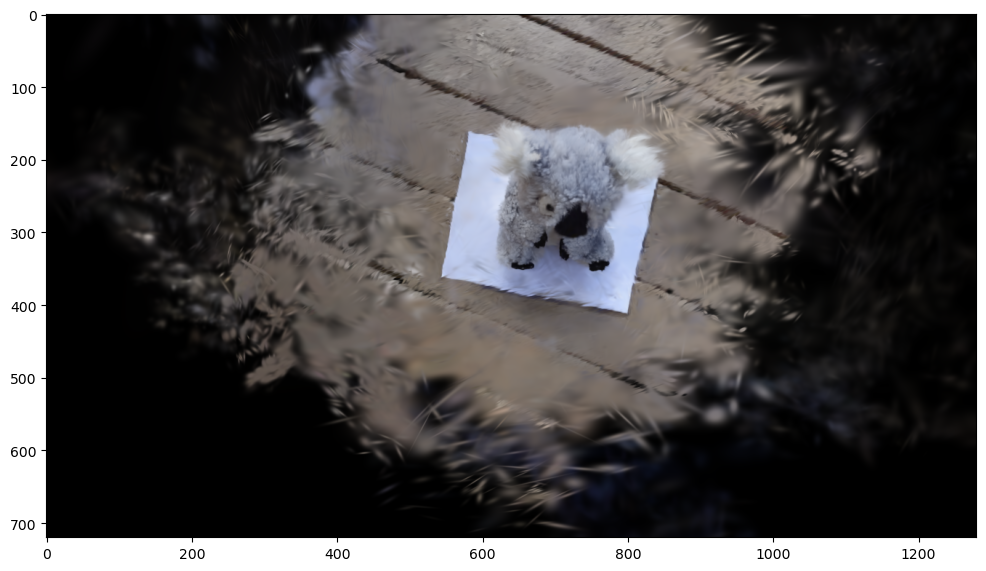

Clustering...


In [ ]:
try:
    koala
except:
    print('Loading...')
    koala = load_gaussians('koala_stuffie.ply')

input_gaussians = koala

(h, w) = (720, 1280)
camera = Camera(h, w, position=(0.0, 0.0, -1.0), target=(0.0, 0.5, 0.0))
bitmap = plot_model(camera, input_gaussians)
plt.figure(figsize=(12, 12))
plt.imshow(bitmap, vmin=0, vmax=1.0)
plt.show()

for i in range(10):
    n_clusters = len(input_gaussians) // 10
    if n_clusters == 0:
        break

    print('Clustering...')
    labels, kmeans_model = cluster_gaussians(input_gaussians, n_clusters=n_clusters)

    clustered_gaussians = {}
    for i, g in enumerate(input_gaussians):
        if labels[i] not in clustered_gaussians:
            clustered_gaussians[labels[i]] = []
        clustered_gaussians[labels[i]].append(g)

    print('Merging...')
    merged_gaussians = [ merge_gaussians(clustered_gaussians[i]) for i in tqdm(range(n_clusters)) ]
    save_ply(f'koala_stuffie_lod{i + 1}.ply', merged_gaussians)

    input_gaussians = merged_gaussians
    bitmap = plot_model(camera, input_gaussians)
    plt.figure(figsize=(12, 12))
    plt.imshow(bitmap, vmin=0, vmax=1.0)
    plt.show()